## NLP Analysis of Reddit Comments

#### Semantic Search and Topic Modeling

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
# load data
all_comments = pd.read_csv('/content/drive/MyDrive/Applied Paper /data/all_subreddit_comments.csv')

<ipython-input-3-6c35ce8c21f2>:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  all_comments = pd.read_csv('/content/drive/MyDrive/Applied Paper /data/all_subreddit_comments.csv')


In [4]:
# set corpus as a list of all the comments in the data set
corpus = list(all_comments['comment_body'])
all_comments.head()

,comment_id,comment_body,comment_link_id,comment_utc,comment_subreddit,comment_upvotes,date
0,dr324ax,[deleted],t3_7j1w9l,NaN,NaN,NaN,NaN
1,dr34t24,"NASA : ""So instead of finding X planets every ...",t3_7j1w9l,NaN,NaN,NaN,NaN
2,dr34plh,I also read that Google is involved and taking...,t3_7j1w9l,NaN,NaN,NaN,NaN
3,dr342uy,This is like taking a little kid to the beach....,t3_7j1w9l,NaN,NaN,NaN,NaN
4,dr32wu2,More details here:\n\nhttps://science.slashdot...,t3_7j1w9l,NaN,NaN,NaN,NaN


In [5]:
print('total number of comments before semantic search:', len(all_comments))

total number of comments before semantic search: 187029


### Encoding

In [ ]:
# use batching to encode in waves
import torch
from sentence_transformers import SentenceTransformer, util

# Load the pre-trained model
model = SentenceTransformer('all-MiniLM-L6-v2') # a fast sentence transformer

# Set batch size
batch_size = 1000

# Initialize an empty list to store the encoded embeddings
encoded_embeddings_list = []

# Iterate through the corpus in batches
for i in range(0, len(corpus), batch_size):
    batch_sentences = corpus[i:i + batch_size]

    # Encode the batch
    batch_embeddings = model.encode(batch_sentences, convert_to_tensor=True)

    # Append the batch embeddings to the list
    encoded_embeddings_list.append(batch_embeddings)

# Concatenate the batch embeddings along the specified axis (dimension)
corpus_embeddings = torch.cat(encoded_embeddings_list, dim=0)


.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

### Cosine Similarity

In [ ]:
import torch

# get embedding for search query
search_query = "How will the rise of artificial intelligence (AI) in organizations impact employees?"

# Query sentence(s):
query = ["How will the rise of artificial intelligence (AI) in organizations impact employees?"]

# create embedding for query
query_embedding = model.encode(query, convert_to_tensor=True)

# Find the closest 2000 sentences of the corpus for each query sentence based on cosine similarity (double the recommended minimum for topic modeling)
top_k = min(2000, len(corpus))

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]

# using torch get the top score
top_results = torch.topk(cos_scores, k = top_k)


In [ ]:
# Create an empty list to store DataFrames
dfs = []

# Iterate through the top results and create DataFrames for each result
for idx in top_results.indices:
    comment = corpus[idx]
    cosine_similarity = cos_scores[idx].item()

    df = pd.DataFrame({'Comment': [comment], 'Cosine_Similarity': [cosine_similarity]})
    dfs.append(df)

# Concatenate the list of DataFrames into a single DataFrame
result_df = pd.concat(dfs, ignore_index=True)

In [ ]:
result_df

,Comment,Cosine_Similarity
0,How is that different than AI’s impact on any ...,0.756999
1,Innovation has been reducing jobs since the be...,0.755889
2,Whether or no AI will replace jobs in the futu...,0.740383
3,You can’t compare the introduction of computer...,0.732290
4,"AI has the power to enhance what we do, but no...",0.727734
...,...,...
1995,Why should we think of general AI differently ...,0.522861
1996,Ai will always be an if on the grid and empowe...,0.522858
1997,Here comes the AI strikes,0.522832
1998,Ya the media loves to hype up any AI story or ...,0.522810


In [ ]:
# finally match the data back to the orignal data set using the comments themselves

# Merge the original DataFrame with the result_df on the 'Comment' column
merged_data = pd.merge(result_df, all_comments, how = 'left',
                       left_on = 'Comment', right_on = 'comment_body')

# Display the merged DataFrame
merged_data.head()


,Comment,Cosine_Similarity,comment_id,comment_body,comment_link_id,comment_utc,comment_subreddit,comment_upvotes,date
0,How is that different than AI’s impact on any ...,0.756999,irn35hr,How is that different than AI’s impact on any ...,t3_xzf2m4,1665327697.0,tech,1.0,2022-10-09 15:01:37+00:00
1,Innovation has been reducing jobs since the be...,0.755889,k19uc08,Innovation has been reducing jobs since the be...,t3_16mre26,1695131989.0,Economics,329.0,2023-09-19 13:59:49+00:00
2,Whether or no AI will replace jobs in the futu...,0.740383,k1a0jo0,Whether or no AI will replace jobs in the futu...,t3_16mre26,1695134347.0,Economics,10.0,2023-09-19 14:39:07+00:00
3,You can’t compare the introduction of computer...,0.732290,g69kl5g,You can’t compare the introduction of computer...,t3_ixqmym,NaN,NaN,NaN,NaN
4,"AI has the power to enhance what we do, but no...",0.727734,j3n3edh,"AI has the power to enhance what we do, but no...",t3_107lxum,1673289638.0,humanresources,11.0,2023-01-09 18:40:38+00:00


In [ ]:
# inspect Cosine Similarity scores
merged_data.Cosine_Similarity.describe()

count    2000.000000
mean        0.573384
std         0.041795
min         0.522710
25%         0.539647
50%         0.562072
75%         0.599142
max         0.756999
Name: Cosine_Similarity, dtype: float64

In [ ]:
# inspect min and max dates
merged_data.sort_values(by = 'date', ascending = True).head()

,Comment,Cosine_Similarity,comment_id,comment_body,comment_link_id,comment_utc,comment_subreddit,comment_upvotes,date
1423,> That'll require the development of artificia...,0.542960,c0r8t7z,> That'll require the development of artificia...,t3_ca8rx,1275476190.0,business,1.0,2010-06-02 10:56:30+00:00
1961,The problem is current computers are bound to ...,0.524029,c190nid,The problem is current computers are bound to ...,t3_elikp,1292331791.0,Economics,3.0,2010-12-14 13:03:11+00:00
1097,There will always be a need for employees. Som...,0.556285,c1919zw,There will always be a need for employees. Som...,t3_elikp,1292343877.0,Economics,1.0,2010-12-14 16:24:37+00:00
392,There's a difference between automation and AI...,0.611021,c1jdg55,There's a difference between automation and AI...,t3_fxesi,1299280994.0,Economics,5.0,2011-03-04 23:23:14+00:00
1972,>artificially keep less-efficient jobs around ...,0.523671,c1jdq9w,>artificially keep less-efficient jobs around ...,t3_fxesi,1299285247.0,Economics,2.0,2011-03-05 00:34:07+00:00


In [ ]:
# store the records to drive
# storing a new, larger set with 2,000 comments now
#merged_data.to_csv('/content/drive/MyDrive/Applied Paper /data/semantic_search_comments_large.csv')


In [8]:
# load merged data set to start here - semantic search commments large
merged_data = pd.read_csv("/content/drive/MyDrive/Applied Paper /data/semantic_search_comments_large.csv")

print(len(merged_data))

merged_data.head()

2000


,Unnamed: 0,Comment,Cosine_Similarity,comment_id,comment_body,comment_link_id,comment_utc,comment_subreddit,comment_upvotes,date
0,0,How is that different than AI’s impact on any ...,0.756999,irn35hr,How is that different than AI’s impact on any ...,t3_xzf2m4,1.665328e+09,tech,1.0,2022-10-09 15:01:37+00:00
1,1,Innovation has been reducing jobs since the be...,0.755889,k19uc08,Innovation has been reducing jobs since the be...,t3_16mre26,1.695132e+09,Economics,329.0,2023-09-19 13:59:49+00:00
2,2,Whether or no AI will replace jobs in the futu...,0.740383,k1a0jo0,Whether or no AI will replace jobs in the futu...,t3_16mre26,1.695134e+09,Economics,10.0,2023-09-19 14:39:07+00:00
3,3,You can’t compare the introduction of computer...,0.732290,g69kl5g,You can’t compare the introduction of computer...,t3_ixqmym,NaN,NaN,NaN,NaN
4,4,"AI has the power to enhance what we do, but no...",0.727734,j3n3edh,"AI has the power to enhance what we do, but no...",t3_107lxum,1.673290e+09,humanresources,11.0,2023-01-09 18:40:38+00:00


## Topic Modeling using BERTopic


In [10]:
!pip install -q BERTopic
!pip install -q sentence-transformers``

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 19.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 8.5 MB/s eta 0:00:00


In [11]:
# specify the topic model and modular components
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer

# embedding model


# dim reduction model to limit matrix sparsity
umap_model = UMAP(n_neighbors = 15, n_components = 5, min_dist = 0.0, metric = 'cosine')

# cluster model - higher min cluster size will generate fewer topics
# lower min samples to minimize number of outliers
hdbscan_model = HDBSCAN(min_cluster_size = 15, min_samples = 5, metric = 'euclidean',
                        cluster_selection_method = 'eom', prediction_data = True)

# vectorizer model - comment this one out for now; come back to it to improve fit as desired
vectorizer_model = CountVectorizer(ngram_range= (1,3), stop_words = 'english')

# c-TF-IDF model
ctfidf_model = ClassTfidfTransformer()


# representation model
keybert_model = KeyBERTInspired()

# instantiate the topic model with components loaded above

topic_model = BERTopic(embedding_model="all-MiniLM-L6-v2",
                       umap_model = umap_model,
                       hdbscan_model = hdbscan_model,
                       ctfidf_model = ctfidf_model,
                       representation_model = keybert_model, nr_topics = 'auto')

In [12]:
# store comments in list format, which BERTopic use

ai_comments = list(merged_data.Comment)

# ensure same length of 2,000 comments
len(ai_comments)

2000

In [13]:
# fit the topic model
ai_topics = topic_model.fit(documents = ai_comments)

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [14]:
# initial inspection of topics
ai_topics.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,859,-1_ai_automation_technology_intelligence,"[ai, automation, technology, intelligence, job...",[1. It's capital intensive to do this for most...
1,0,267,0_ai_intelligence_technology_society,"[ai, intelligence, technology, society, future...","[Software developer here, I don't think you sh..."
2,1,243,1_ai_automation_machines_industry,"[ai, automation, machines, industry, jobs, tec...",[You're absolutely right about a lack of flexi...
3,2,95,2_ai_economic_capitalism_wealth,"[ai, economic, capitalism, wealth, labor, soci...",[His argument is based on both a false image o...
4,3,85,3_automation_productivity_labor_automated,"[automation, productivity, labor, automated, t...",[> The issue at hand is that with every improv...
5,4,72,4_ai_recruitment_hr_recruiters,"[ai, recruitment, hr, recruiters, hiring, hris...","[I liked the article, don’t get me wrong. In f..."
6,5,60,5_robots_robot_artificial_intelligence_homo_sa...,"[robots, robot, artificial_intelligence_homo_s...",[Well then the people in those fields are in s...
7,6,49,6_consulting_consultants_consultant_ai,"[consulting, consultants, consultant, ai, clie...",[You could’ve just asked gpt3:\n\n> Artificial...
8,7,31,7_automation_ai_machine_jobs,"[automation, ai, machine, jobs, computer, proc...",[Automation can go really fast. The reason why...
9,8,29,8_ubi_ai_automation_technology,"[ubi, ai, automation, technology, machines, jo...",[ If AI is takes all the jobs from workers the...


In [20]:
# further reduce topics
ai_topics = topic_model.reduce_topics(ai_comments, nr_topics = 12)

# adjust topic labels so that they are more coherent
topic_labels = topic_model.generate_topic_labels(nr_words=3,
                                                 topic_prefix=False,
                                                 word_length=10,
                                                 separator=", ")

# now apply to overwrite the original topic labels
topic_model.set_topic_labels(topic_labels)

# inspect
ai_topics.get_topic_info()

,Topic,Count,Name,CustomName,Representation,Representative_Docs
0,-1,859,-1_ai_automation_technology_intelligence,"ai, automation, technology","[ai, automation, technology, intelligence, job...",[1. It's capital intensive to do this for most...
1,0,580,0_ai_automation_intelligence_technology,"ai, automation, intelligen","[ai, automation, intelligence, technology, fut...",[1. Up to 47% of jobs in the Western Hemispher...
2,1,145,1_robots_automation_machines_productivity,"robots, automation, machines","[robots, automation, machines, productivity, a...",[The problem is it is easy to point out all of...
3,2,130,2_ai_capitalism_wealth_corporations,"ai, capitalism, wealth","[ai, capitalism, wealth, corporations, labor, ...",[If Ai can take all the jobs or even majority ...
4,3,121,3_ai_consulting_consultants_recruitment,"ai, consulting, consultant","[ai, consulting, consultants, recruitment, hir...","[No, it's not even nearly as ""child's play"" as..."
5,4,29,4_ubi_ai_automation_technology,"ubi, ai, automation","[ubi, ai, automation, technology, machines, jo...",[ If AI is takes all the jobs from workers the...
6,5,28,5_ai_ceo_ceos_leadership,"ai, ceo, ceos","[ai, ceo, ceos, leadership, board, responsibil...","[>Let's replace board members, CEOs, and other..."
7,6,28,6_patents_patent_ai_patentable,"patents, patent, ai","[patents, patent, ai, patentable, patented, in...",[> If courts and governments decide that AI-ma...
8,7,26,7_ai_jobs_chatgpt_chat,"ai, jobs, chatgpt","[ai, jobs, chatgpt, chat, bots, office, manage...",[Its sociopathic to think AI ChatGPT is a good...
9,8,19,8_ai_healthcare_medical_medicine,"ai, healthcare, medical","[ai, healthcare, medical, medicine, doctors, i...",[As AI gets more specialized in the medical fi...


In [28]:
ai_topics.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,859,-1_ai_automation_technology_intelligence,"[ai, automation, technology, intelligence, job...",[1. It's capital intensive to do this for most...
1,0,580,0_ai_automation_intelligence_technology,"[ai, automation, intelligence, technology, fut...",[1. Up to 47% of jobs in the Western Hemispher...
2,1,180,1_robots_productivity_automation_ai,"[robots, productivity, automation, ai, technol...",[The problem is it is easy to point out all of...
3,2,130,2_ai_capitalism_wealth_corporations,"[ai, capitalism, wealth, corporations, labor, ...",[If Ai can take all the jobs or even majority ...
4,3,121,3_ai_consulting_consultants_recruitment,"[ai, consulting, consultants, recruitment, hir...","[No, it's not even nearly as ""child's play"" as..."
5,4,29,4_ubi_ai_automation_technology,"[ubi, ai, automation, technology, machines, jo...",[ If AI is takes all the jobs from workers the...
6,5,28,5_ai_ceo_ceos_leadership,"[ai, ceo, ceos, leadership, board, responsibil...","[>Let's replace board members, CEOs, and other..."
7,6,28,6_patents_patent_ai_patentable,"[patents, patent, ai, patentable, patented, in...",[> If courts and governments decide that AI-ma...
8,7,26,7_ai_jobs_chatgpt_chat,"[ai, jobs, chatgpt, chat, bots, office, manage...",[Its sociopathic to think AI ChatGPT is a good...
9,8,19,8_ai_healthcare_medical_medicine,"[ai, healthcare, medical, medicine, doctors, i...",[As AI gets more specialized in the medical fi...


In [26]:
# merge topics 1 and 9 which are both about job automation

topics_to_merge = [1,9]


# merge topics ... this stores the smaller set of topics back to the topic model so
# only need to run this once
topic_model.merge_topics(ai_comments, topics_to_merge)


IndexError: ignored

In [27]:
# now inspect the topics again
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,859,-1_ai_automation_technology_intelligence,"[ai, automation, technology, intelligence, job...",[1. It's capital intensive to do this for most...
1,0,580,0_ai_automation_intelligence_technology,"[ai, automation, intelligence, technology, fut...",[1. Up to 47% of jobs in the Western Hemispher...
2,1,180,1_robots_productivity_automation_ai,"[robots, productivity, automation, ai, technol...",[The problem is it is easy to point out all of...
3,2,130,2_ai_capitalism_wealth_corporations,"[ai, capitalism, wealth, corporations, labor, ...",[If Ai can take all the jobs or even majority ...
4,3,121,3_ai_consulting_consultants_recruitment,"[ai, consulting, consultants, recruitment, hir...","[No, it's not even nearly as ""child's play"" as..."
5,4,29,4_ubi_ai_automation_technology,"[ubi, ai, automation, technology, machines, jo...",[ If AI is takes all the jobs from workers the...
6,5,28,5_ai_ceo_ceos_leadership,"[ai, ceo, ceos, leadership, board, responsibil...","[>Let's replace board members, CEOs, and other..."
7,6,28,6_patents_patent_ai_patentable,"[patents, patent, ai, patentable, patented, in...",[> If courts and governments decide that AI-ma...
8,7,26,7_ai_jobs_chatgpt_chat,"[ai, jobs, chatgpt, chat, bots, office, manage...",[Its sociopathic to think AI ChatGPT is a good...
9,8,19,8_ai_healthcare_medical_medicine,"[ai, healthcare, medical, medicine, doctors, i...",[As AI gets more specialized in the medical fi...


In [30]:
# store topic labels back to the row with the original comments

ai_comments_with_labels = ai_topics.get_document_info(ai_comments)

# right join the labeled data and topic probabilities we get from above onto original data frame
comments_and_topics_df = merged_data.join(ai_comments_with_labels,
                                          how = 'right')

# inspect joined data
comments_and_topics_df.head()

,Unnamed: 0,Comment,Cosine_Similarity,comment_id,comment_body,comment_link_id,comment_utc,comment_subreddit,comment_upvotes,date,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,0,How is that different than AI’s impact on any ...,0.756999,irn35hr,How is that different than AI’s impact on any ...,t3_xzf2m4,1.665328e+09,tech,1.0,2022-10-09 15:01:37+00:00,How is that different than AI’s impact on any ...,-1,-1_ai_automation_technology_intelligence,"[ai, automation, technology, intelligence, job...",[1. It's capital intensive to do this for most...,ai - automation - technology - intelligence - ...,0.000000,False
1,1,Innovation has been reducing jobs since the be...,0.755889,k19uc08,Innovation has been reducing jobs since the be...,t3_16mre26,1.695132e+09,Economics,329.0,2023-09-19 13:59:49+00:00,Innovation has been reducing jobs since the be...,-1,-1_ai_automation_technology_intelligence,"[ai, automation, technology, intelligence, job...",[1. It's capital intensive to do this for most...,ai - automation - technology - intelligence - ...,0.000000,False
2,2,Whether or no AI will replace jobs in the futu...,0.740383,k1a0jo0,Whether or no AI will replace jobs in the futu...,t3_16mre26,1.695134e+09,Economics,10.0,2023-09-19 14:39:07+00:00,Whether or no AI will replace jobs in the futu...,0,0_ai_automation_intelligence_technology,"[ai, automation, intelligence, technology, fut...",[1. Up to 47% of jobs in the Western Hemispher...,ai - automation - intelligence - technology - ...,0.732565,False
3,3,You can’t compare the introduction of computer...,0.732290,g69kl5g,You can’t compare the introduction of computer...,t3_ixqmym,NaN,NaN,NaN,NaN,You can’t compare the introduction of computer...,-1,-1_ai_automation_technology_intelligence,"[ai, automation, technology, intelligence, job...",[1. It's capital intensive to do this for most...,ai - automation - technology - intelligence - ...,0.000000,False
4,4,"AI has the power to enhance what we do, but no...",0.727734,j3n3edh,"AI has the power to enhance what we do, but no...",t3_107lxum,1.673290e+09,humanresources,11.0,2023-01-09 18:40:38+00:00,"AI has the power to enhance what we do, but no...",3,3_ai_consulting_consultants_recruitment,"[ai, consulting, consultants, recruitment, hir...","[No, it's not even nearly as ""child's play"" as...",ai - consulting - consultants - recruitment - ...,0.266998,False


In [31]:
# store joined data
comments_and_topics_df.to_csv('/content/drive/MyDrive/Applied Paper /data/comments_with_topic_labels_v2.csv')

In [ ]:
ai_topics.get_topic_info()

,Topic,Count,Name,CustomName,Representation,Representative_Docs
0,-1,663,-1_ai_automation_technology_machines,"ai, automation, technology","[ai, automation, technology, machines, intelli...",[>...then it should also be significantly chea...
1,0,839,0_ai_automation_jobs_human,"ai, automation, jobs","[ai, automation, jobs, human, make, just, more...",[I work in this space and it has been my opini...
2,1,189,1_robots_machines_productivity_ai,"robots, machines, productivi","[robots, machines, productivity, ai, technolog...",[There are substantial differences between com...
3,2,121,2_ai_consulting_consultants_recruitment,"ai, consulting, consultant","[ai, consulting, consultants, recruitment, hir...","[No, it's not even nearly as ""child's play"" as..."
4,3,31,3_ai_ceo_ceos_leadership,"ai, ceo, ceos","[ai, ceo, ceos, leadership, companies, hire, l...","[>Let's replace board members, CEOs, and other..."
5,4,29,4_ubi_ai_automation_technology,"ubi, ai, automation","[ubi, ai, automation, technology, machines, jo...",[ If AI is takes all the jobs from workers the...
6,5,28,5_ai_jobs_chatgpt_chat,"ai, jobs, chatgpt","[ai, jobs, chatgpt, chat, bots, office, manage...",[Its sociopathic to think AI ChatGPT is a good...
7,6,28,6_patents_patent_ai_patentable,"patents, patent, ai","[patents, patent, ai, patentable, patented, in...",[> If courts and governments decide that AI-ma...
8,7,20,7_ai_automation_industrial_sentient,"ai, automation, industrial","[ai, automation, industrial, sentient, product...",[The difference is that AI has the ability to ...
9,8,19,8_ai_corporations_enterprises_inventors,"ai, corporatio, enterprise","[ai, corporations, enterprises, inventors, com...","[No, no, I mean the AI would be the capital ow..."


### Topic Model Data Viz

In [1]:
bar_chart = ai_topics.visualize_barchart(n_words = 5, top_n_topics = 10, width = 250,
                             custom_labels = False)

bar_chart

NameError: ignored

In [33]:
ai_topics.visualize_heatmap(custom_labels = False, width = 1000,
                            n_clusters = 3, title = 'Topic Similarity Matrix')


In [ ]:
ai_topics.visualize_topics(custom_labels = True)

In [34]:
comments_and_topics_df['datetime'] = pd.to_datetime(comments_and_topics_df['date'], utc = True)

# now a new column with only year
comments_and_topics_df['year'] = comments_and_topics_df['datetime'].dt.year

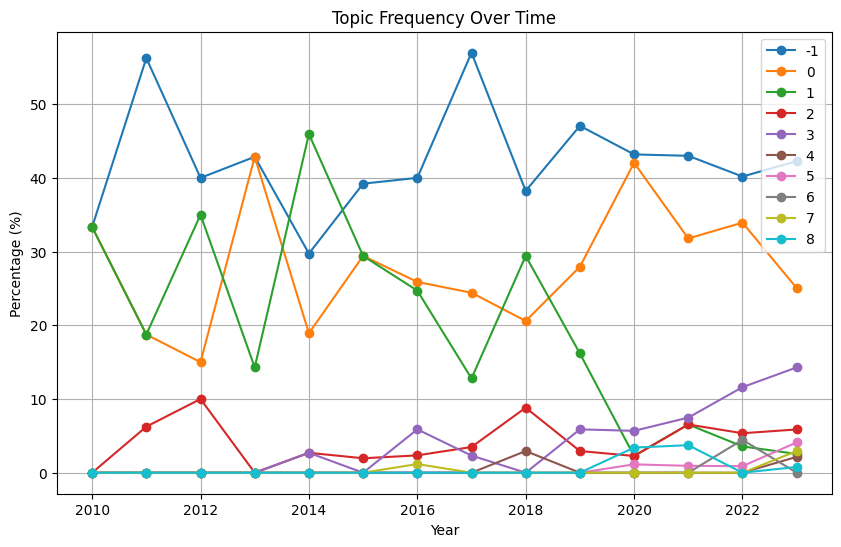

In [36]:
# Group by 'year_column' and 'Topic_column' and calculate the percentage
grouped_data = comments_and_topics_df.groupby(['year', 'Topic']).size().unstack(fill_value=0)
percentage_data = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

# Plotting the line chart for each topic
plt.figure(figsize=(10, 6))
for topic, color in zip(percentage_data.columns, plt.cm.tab10.colors):
    plt.plot(percentage_data.index, percentage_data[topic], marker='o', linestyle='-', label=topic, color=color)

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.title('Topic Frequency Over Time')

# Display legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

In [39]:
# Remove rows where 'Topic' is -1 or 8
merged_data = comments_and_topics_df[comments_and_topics_df['Topic'].isin([1,2,4,5,9,10])]  # Assuming valid topic values

# Group by 'year' and 'Topic' and calculate the mean of 'comment_upvotes'
grouped_data = merged_data.groupby(['year', 'Topic']).mean()['comment_upvotes'].unstack(fill_value=0)

# Plotting the line chart for each topic
plt.figure(figsize=(10, 6))
for topic, color in zip(grouped_data.columns, plt.cm.tab10.colors):
    if topic in grouped_data.columns:
        # Annotate each line using the 'CustomName' column
        label = merged_data[merged_data['Topic'] == topic]['CustomName'].iloc[0]
        plt.plot(grouped_data.index, grouped_data[topic], marker='o', linestyle='-', label=label, color=color)

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Mean Comment Upvotes')
plt.title('Mean Comment Upvotes Over Time')

# Display legend
plt.legend()

# Remove gridlines
plt.grid(False)

# Display the plot
plt.show()

KeyError: ignored

<Figure size 1000x600 with 0 Axes>

In [40]:
# Identify the top 5 most frequent topics
top_topics = comments_and_topics_df['Topic'].value_counts().head(5).index

# Filter data for the top 5 topics
merged_data = comments_and_topics_df[comments_and_topics_df['Topic'].isin(top_topics)]

# Group by 'year' and 'Topic' and calculate the mean of 'comment_upvotes'
grouped_data = merged_data.groupby(['year', 'Topic']).mean()['comment_upvotes'].unstack(fill_value=0)

# Plotting the line chart for each top topic
plt.figure(figsize=(10, 6))
for topic, color in zip(top_topics, plt.cm.tab10.colors):
    if topic in grouped_data.columns:
        # Annotate each line using the 'CustomName' column
        label = merged_data[merged_data['Topic'] == topic]['CustomName'].iloc[0]
        plt.plot(grouped_data.index, grouped_data[topic], marker='o', linestyle='-', label=label, color=color)

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Mean Comment Upvotes')
plt.title('Mean Comment Upvotes Over Time (Top 5 Frequent Topics)')

# Display legend
plt.legend()

# Remove gridlines
plt.grid(False)

# Display the plot
plt.show()

KeyError: ignored

<Figure size 1000x600 with 0 Axes>

In [ ]:
grouped_data.sum().sort_values(ascending=False).head(10)

Topic
1     61.243362
2     19.768822
3     18.391304
4     17.272727
9      7.500000
10     3.200000
5      2.812500
dtype: float64

## Guided Topic Model


In [ ]:
from bertopic import BERTopic


docs = ai_comments

seed_topic_list = [['Psychological Contract Breach (PCB)', 'Almost all the promises made by my organization during recruitment have been kept so far',
                    'I feel that my organization has come through in fulfilling the promises made to me when I was hired',
                    "So far my organization has done an excellent job of fulfilling its promises to me",
                    "I have received everything promised to me in exchange for my contributions", "My organization has kept many of its promises to me"],
                   ['social isolation', "loneliness", 'well-being', 'collaboration', 'vulnerable'],
                   ["trust in organization", 'ethical leadership', 'transparency', 'psychological safety'],
                   ["upskilling", 'organizational change', 'speed of change', 'disruption']]

guided_topic_model = BERTopic(seed_topic_list=seed_topic_list,
                              embedding_model="all-MiniLM-L6-v2",
                       umap_model = umap_model,
                       hdbscan_model = hdbscan_model,
                       ctfidf_model = ctfidf_model,
                       representation_model = keybert_model, nr_topics = 'auto')
guided_topics = guided_topic_model.fit(docs)


In [ ]:
guided_topics.get_topic_info()

In [ ]:
guided_topics.fit(nr_topics = 'auto')